# Khai báo thư viện

In [ ]:
import torch
import torch.utils.data as Data
import torch.nn as nn
import torchvision.transforms as transforms
from csv import reader
import numpy as np
import pandas as pd
from prettytable import PrettyTable
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Set device
cuda = True if torch.cuda.is_available() else False

In [ ]:
class ConvertToDatasetGRU(Data.Dataset):

    """
        Support class for the loading and batching of sequences of samples

        Args:
            dataset (Tensor): Tensor containing all the samples
            sequence_length (int): length of the analyzed sequence by the LSTM
            transforms (object torchvision.transform): Pytorch's transforms used to process the data
    """

    ##  Constructor
    def __init__(self, data, sequence_length, transforms=None):
        self.seq_length = sequence_length
        self.transforms = transforms
        self.dataset = list(np.float_(data.iloc[:,0:53]))
        self.labels = list(np.float_(data.iloc[:,53]))


    def __len__(self):
        return self.dataset.__len__()
        #return 175341

    ##  Override single items' getter
    def __getitem__(self, idx):
            if self.transforms is not None:
              return self.transforms(self.dataset[idx:idx+self.seq_length]), self.labels[idx+self.seq_length-1]
            else:
              return self.dataset[idx:idx+self.seq_length], self.labels[idx+self.seq_length-1]

###   Helper for transforming the data from a list to Tensor
def listToTensor(list):
    tensor = torch.empty(list.__len__(), list[0].__len__())
    for i in range(list.__len__()):
        tensor[i, :] = torch.FloatTensor(list[i])
    return tensor

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Định nghĩa thông số

In [ ]:
# Parameters
seq_length = 30
batch_size = 100
input_size = 53
hidden_size = 128
num_layers = 3
num_classes = 1
learning_rate = 0.0001

# Load Train Dataset

In [ ]:
data_transform = transforms.Lambda(lambda x: listToTensor(x))

data = pd.read_csv('drive/MyDrive/UNSW_NB15_training-set.csv')

dataset = ConvertToDatasetGRU(data, seq_length, transforms=data_transform)
train_loader = Data.DataLoader(dataset, batch_size, shuffle=False, drop_last=True)


# Thiết kế model

In [ ]:
# Fully connected neural network with one hidden layer
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(GRU, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        #self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # -> x needs to be: (batch_size, seq, input_size)
        
        # or:
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=0.1)
        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 10)
        self.fc2 = nn.Linear(10, 1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) 
        #c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        h0 = h0.cuda()
        # x: (n, 28, 28), h0: (2, n, 128)
        
        # Forward propagate RNN
        out, _ = self.gru(x, h0)  
        # or:
        #out, _ = self.lstm(x, (h0,c0))  
        
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        # out: (n, 28, 128)
        
        # Decode the hidden state of the last time step
        out = out[:, -1, :]
        # out: (n, 128)
         
        out = self.fc(out)
        out = self.fc2(out)
        # out: (n, 10)
        return self.sig(out)

# Khởi tạo model và loss function

In [ ]:
model = GRU(input_size, hidden_size, num_layers, num_classes).cuda()
# Loss and optimizer
criterion = nn.BCELoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# TRAIN()

In [ ]:
# Train the model
num_epochs  = 50
loss_history = list()
for epoch in range(num_epochs):
    losses = list()
    for i, (features, label) in enumerate(train_loader):

        labels = label.reshape(batch_size, 1).cuda()
        labels = labels.float()
        features = features.cuda()
        # Forward pass
        outputs = model(features).float()
        loss = criterion(outputs, labels)
        losses.append(loss)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #if (i+1) % 100 == 0:
        #    print(f'Epoch [{epoch+1}/{num_epochs}],  Loss: {loss.item():.10f}')
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    loss_history.append(sum(losses)/len(losses))
    cal_acc()

Epoch [1/50]
68.32686822589847
Epoch [2/50]
90.32972047917855
Epoch [3/50]
94.18824871648603
Epoch [4/50]
94.9281232173417
Epoch [5/50]
94.46833998859098
Epoch [6/50]
95.14204221334855
Epoch [7/50]
95.41186537364518
Epoch [8/50]
95.62236166571591
Epoch [9/50]
95.88533941814033
Epoch [10/50]
95.99942954934399
Epoch [11/50]
96.17969195664575
Epoch [12/50]
96.32059326868226
Epoch [13/50]
96.50427837992014
Epoch [14/50]
96.58014831717057
Epoch [15/50]
96.79121505989733
Epoch [16/50]
96.78551055333713
Epoch [17/50]
97.02395892755277
Epoch [18/50]
97.0342270393611
Epoch [19/50]
97.16314888762122
Epoch [20/50]
97.18083285795778
Epoch [21/50]
97.29378208784941
Epoch [22/50]
97.3810610382202
Epoch [23/50]
97.41585852823731
Epoch [24/50]
97.47860810039931
Epoch [25/50]
97.53337136337707
Epoch [26/50]
97.55790074158585
Epoch [27/50]
97.60410724472334
Epoch [28/50]
97.6468910439247
Epoch [29/50]
97.61323445521963
Epoch [30/50]
97.8031945236737
Epoch [31/50]
97.82030804335425
Epoch [32/50]
97.84940

In [ ]:
torch.save(model.state_dict(), 'drive/MyDrive/Colab Notebooks/model-50epoch') 

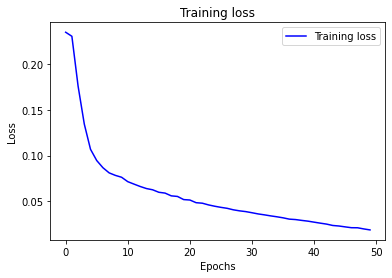

In [ ]:
plot_loss(loss_history, len(loss_history))

# Validation

In [ ]:
def validation(model):
  ## LOAD TEST DATASET
  # read csv file as a list of lists
  #data = pd.read_csv('drive/MyDrive/Learning/Google Colab/GRU/UNSW-NB15-Test.csv')
  data = pd.read_csv('/content/drive/MyDrive/Datasets/UNSW-NB15/UNSW-NB15-Test.csv')

  dataset_test = ConvertToDatasetGRU(data, seq_length, transforms=data_transform)
  test_loader = Data.DataLoader(dataset_test, batch_size, shuffle=False, drop_last=True)

  ## CALCULATE           
  # Test the model
  # In test phase, we don't need to compute gradients (for memory efficiency)
  label = list()
  result = list() 
  output = list()
  n_correct = 0
  i = 0

  with torch.no_grad():
      for features, labels in test_loader:
          #images = images.reshape(-1, sequence_length, input_size).to(device)
          features = features.cuda() #cuda
          labels = labels.cuda()  #cuda
          outputs = model(features).float()
          for x in outputs:
            x = x.cpu().numpy()
            if (x.item()<0.5):
              result.append(0)
            else:
              result.append(1)
            output.append(x)
            
          for x in labels:
            x = x.cpu().numpy()
            if (x.item()<0.5):
              label.append(0)
            else:
              label.append(1)          

      fpr, tpr, thresholds = roc_curve(label, output, pos_label = 1)
      print("Confusion matrix with threshold 0.5:")
      TN = FN = TP = FP = 0
      for i in range(len(label)):
        if label[i] == result[i] == 1:
          TP += 1
          n_correct = n_correct + 1

        if label[i] == result[i] == 0:
          TN += 1
          n_correct = n_correct + 1

        if label[i] != result[i] and label[i] == 1:
          FP += 1

        if label[i] != result[i] and label[i] == 0:
          FN += 1
      plot_confusion_matrix(TP, FP, FN, TN)



      acc = (100.0 * n_correct) / len(label)   
      precision = TP / (TP + FP)
      recall =  TP / (TP + FN)
      F1_score = 2 * (precision * recall) / (precision + recall)

      print(f'Accuracy: {acc} %')
      print(f'Precision: {precision}')
      print(f'Recall: {recall}')
      print(f'f1 score: {F1_score}')

      fpr, tpr, thresholds = roc_curve(label, output, pos_label = 1)

      optimal_threshold = plot_ROC(tpr, fpr, thresholds)

      print("Confusion matrix with threshold {}:" % optimal_threshold)
      TN = FN = TP = FP = 0
      n_correct = 0
      i = 0
      result = list()
      for x in output:
        #x = x.cpu().numpy()
        if (x<optimal_threshold):
          result.append(0)
        else:
          result.append(1)

      for i in range(len(label)):
        if label[i] == result[i] == 1:
          TP += 1
          n_correct = n_correct + 1

        if label[i] == result[i] == 0:
          TN += 1
          n_correct = n_correct + 1

        if label[i] != result[i] and label[i] == 1:
          FP += 1

        if label[i] != result[i] and label[i] == 0:
          FN += 1
      plot_confusion_matrix(TP, FP, FN, TN)
      
      acc = (100.0 * n_correct) / len(label)   
      precision = TP / (TP + FP)
      recall =  TP / (TP + FN)
      F1_score = 2 * (precision * recall) / (precision + recall)

      print(f'Accuracy: {acc} %')
      print(f'Precision: {precision}')
      print(f'Recall: {recall}')
      print(f'f1 score: {F1_score}')


Confusion matrix with threshold 0.5:
+--------------+--------------+------------+
|              | Abnormal (1) | Normal (0) |
+--------------+--------------+------------+
| Abnormal (1) |    45116     |    216     |
|  Normal (0)  |     536      |   36432    |
+--------------+--------------+------------+
Accuracy: 99.08626974483596 %
Precision: 0.995235153975117
Recall: 0.9882590028914396
f1 score: 0.9917348105161349


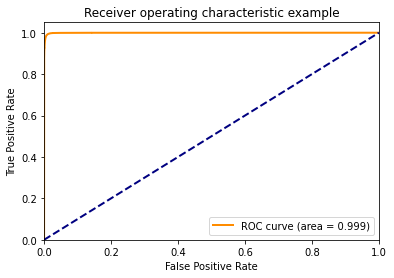

Threshold value is:  0.7213966
Confusion matrix with threshold {}:
+--------------+--------------+------------+
|              | Abnormal (1) | Normal (0) |
+--------------+--------------+------------+
| Abnormal (1) |    45028     |    304     |
|  Normal (0)  |     415      |   36553    |
+--------------+--------------+------------+
Accuracy: 99.12636695018226 %
Precision: 0.9932939204094238
Recall: 0.9908676803908193
f1 score: 0.992079316992564


In [ ]:
validation(model)

In [ ]:
def plot_ROC(tpr, fpr, thresholds):
  plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='darkorange',
          lw=lw, label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc="lower right")
  plt.show()
  optimal_threshold_idx = np.argmax(tpr - fpr)
  optimal_threshold = thresholds[optimal_threshold_idx]
  print("Threshold value is: ", optimal_threshold)
  return optimal_threshold

In [ ]:
def plot_loss(loss_list, epochs):
  epochs = range(0,epochs)
  plt.plot(epochs, loss_list, 'b', label='Training loss')
  plt.title('Training loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [ ]:
def plot_acc(acc_list, epochs):
  #loss_val = history.history['val_acc']
  epochs = range(0,epochs)
  plt.plot(epochs, acc_list, 'r', label='validation accuracy')
  plt.title('Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [ ]:
def plot_confusion_matrix(TP, FP, FN, TN):
  confusion_matrix = PrettyTable(['', 'Abnormal (1)', 'Normal (0)'])
  confusion_matrix.add_row(['Abnormal (1)', TP, FP])
  confusion_matrix.add_row(['Normal (0)', FN, TN])
  print(confusion_matrix)

In [ ]:
model1 = GRU(input_size, hidden_size, num_layers, num_classes).cuda()
model1.load_state_dict(torch.load("drive/MyDrive/Colab Notebooks/model-50epoch"))
model1.eval()

GRU(
  (gru): GRU(53, 128, num_layers=3, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=128, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
  (sig): Sigmoid()
)

Confusion matrix with threshold 0.5:
+--------------+--------------+------------+
|              | Abnormal (1) | Normal (0) |
+--------------+--------------+------------+
| Abnormal (1) |    45111     |    221     |
|  Normal (0)  |     506      |   36462    |
+--------------+--------------+------------+
Accuracy: 99.11664641555285 %
Precision: 0.9951248566134298
Recall: 0.9889076440800578
f1 score: 0.9920065091424863


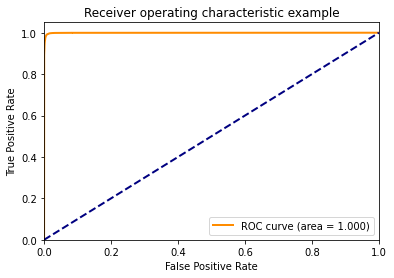

Threshold value is:  0.82569444
Confusion matrix with threshold {}:
+--------------+--------------+------------+
|              | Abnormal (1) | Normal (0) |
+--------------+--------------+------------+
| Abnormal (1) |    44955     |    377     |
|  Normal (0)  |     318      |   36650    |
+--------------+--------------+------------+
Accuracy: 99.15552855407047 %
Precision: 0.991683578928792
Recall: 0.9929759459280366
f1 score: 0.992329341647812


In [ ]:
validation(model1)

In [ ]:
data_test = pd.read_csv('drive/MyDrive/UNSW_NB15_training-set.csv')


dataset_test = ConvertToDatasetGRU(data_test, seq_length, transforms=data_transform)
test_loader = Data.DataLoader(dataset_test, batch_size, shuffle=False, drop_last=True)

In [ ]:
acc_history = list()
def cal_acc():
  ## CALCULATE           
  # Test the model
  # In test phase, we don't need to compute gradients (for memory efficiency)
  label = list()
  result = list()
  output = list()
  n_correct = 0
  i = 0
  with torch.no_grad():
      for features, labels in test_loader:
          #images = images.reshape(-1, sequence_length, input_size).to(device)
          features = features.cuda()
          labels = labels.cuda()
          outputs = model(features).float()
          for x in outputs:
            #x = x.cpu().numpy()
            if (x.item()<0.5):
              result.append(0)
            else:
              result.append(1)
            output.append(x)
            
          for x in labels:
            #x = x.cpu().numpy()
            if (x.item()<0.5):
              label.append(0)
            else:
              label.append(1)          
      for i in range(len(label)):
        if label[i] == result[i]:
          n_correct = n_correct + 1

      acc = (100.0 * n_correct) / len(label)   
      acc_history.append(acc)
      print(acc)


In [ ]:
data = pd.read_csv('./a.csv')

dataset = list(np.float_(data.iloc[0:199,0]))

In [ ]:
print(dataset)

In [ ]:
plot_acc(dataset,len(dataset))

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
